# Simulation - Projet

## Importation des modules nécessaires

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import math
import seaborn as sns
import pandas as pd
import random

## Répartition des décimales d’exponentielle

### Premier aperçu

In [85]:
def e_numbers():
    with open("exp.txt", "r") as e:
        for line in e:
            line = line.strip()
            if "." in line:
                line = line.split(".")[1]
            for c in line:
                yield int(c)

e_numbers = np.array(list(e_numbers()))
print(f'Les 2.000.000 premières décimales d\' exp :\n {e_numbers}')

Les 2.000.000 premières décimales d' exp :
 [7 1 8 ... 0 2 3]


In [86]:
def count_number(data):
    values, counts = np.unique(data, return_counts=True)
    return values, counts

e_labels, e_counts = count_number(e_numbers)
print(f'Les chiffres apparaissant dans les décimales d\' exp : \n {e_labels}')
print(f'Leur fréquences d\'apparition : \n {e_counts}')

Les chiffres apparaissant dans les décimales d' exp : 
 [0 1 2 3 4 5 6 7 8 9]
Leur fréquences d'apparition : 
 [199093 200171 199471 200361 199923 200285 200395 199789 200098 200414]


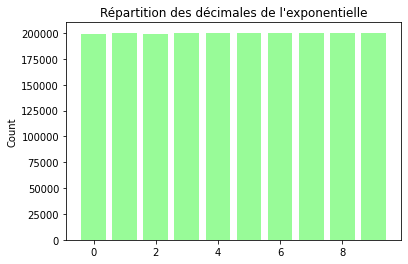

In [87]:
def construct_hist(labels, counts):
    plt.figure()
    plt.bar(labels, counts, color='palegreen')
    plt.title('Répartition des décimales de l\'exponentielle')
    plt.ylabel('Count')
    plt.savefig('histo_exp.png')
    plt.show()

construct_hist(e_labels, e_counts)

### Test du Chi-Carré

In [88]:
def chi_squarred(observed, theorical):
    kr = np.sum(((observed-theorical)**2)/theorical)
    critical = stat.chi2.ppf(q=0.95, df=len(observed)-1)
    return kr <= critical, kr, critical

def chi_squared_uniform(observed):
    proba = 1 / len(observed)
    N = sum(observed)
    theorical = np.array([N * proba for _ in range(len(observed))])
    return chi_squarred(observed, theorical)

print(f"Test du Chi-Carré pour les décimales d'exponentiells : \n"
      f"{chi_squared_uniform(e_counts)}")

Test du Chi-Carré pour les décimales d'exponentiells : 
(True, 8.65376, 16.918977604620448)


### Test du Poker

In [89]:
def poker_test(data):
    number_lists = len(data)/4
    lists = np.split(data, number_lists)
    all_diff = 0
    one_pair = 0
    two_pair = 0
    triplet = 0
    quadr = 0
    for li in lists:
        vals, cts = np.unique(li, return_counts=True)
        if len(cts) == 4:
            all_diff += 1
        elif len(cts) == 3:
            one_pair += 1
        elif len(cts) == 2:
            if 3 in cts:
                triplet += 1
            else:
                two_pair += 1
        else:
            quadr += 1
    return chi_squarred_poker(np.array([all_diff, one_pair, triplet, two_pair, quadr]), len(lists))

def chi_squarred_poker(observed, N):    # P(all_diff) > P(one_pair) > P(triplet) > P(two_pair) > P(quadr)
    probas = np.array([0.504, 0.432, 0.036, 0.027, 0.001])
    theorical = probas * N
    return chi_squarred(observed, theorical)

print(f"Test du Poker pour les décimales d\'exponentielle : \n"
      f"{poker_test(e_numbers)}")

Test du Poker pour les décimales d'exponentielle : 
(True, 1.2631547619047618, 9.487729036781154)


### Test du gap

In [90]:
def gap_test(data, a: int = 0, b: int = 5, total_numbers: int = 10):
    assert a < b
    probability = (b - a) / total_numbers  # => proba 1/2 d'être marqué
    intervals = []
    length_series_not_in = 0
    total_gaps = 0
    sequence_length = 0
    for nb in data:
        if a <= nb < b:
            # nb in interval, with probability `probability`
            intervals.append(length_series_not_in)
            length_series_not_in = 1
        else:
            # nb not in interval
            length_series_not_in += 1
            total_gaps += 1
        sequence_length += 1
    labels, observed = np.unique(np.array(intervals), return_counts=True)
    observed = complete_labels(labels, observed)
    theorical = np.array([probability ** (n + 1) for n in range(max(labels))])*sum(observed)
    return chi_squarred(observed, theorical)

def complete_labels(labels, observed):
    i = 1
    j = 0
    n = 1
    res = []
    while j < len(labels):
        label = labels[j]
        if i != label:
            res.append(0)
            n += 1
        else:
            res.append(observed[i-n])
            j += 1
        i += 1
    return np.array(res)

print(f"Test du Gap pour les décimales d'exponentielle : \n "
      f"{gap_test(e_numbers)}")

Test du Gap pour les décimales d'exponentielle : 
 (True, 21.519255874365697, 33.92443847144381)


## Générateur de nombres aléatoires

### Technique employée

In [96]:
NB_DIGITS = 10

def generator(n: int = 1, seed_: int = 0):
    for i in range(n):
        digits = []
        for k in range(NB_DIGITS):
            seed = e_numbers[seed_ + i + k]
            a = len(e_numbers) - seed
            c = e_numbers[i + seed]
            digit = (a * seed + c) % 10
            digits.append(digit)
        yield float("0." + "".join(map(lambda x: str(x), digits)))

gen_numbers = list(generator(2500, 50))
print(f"Résultat de notre générateur : \n"
      f"{gen_numbers}")

Résultat de notre générateur : 
[0.3632322323, 0.3954664696, 0.5282282524, 0.6988986876, 0.39939094, 0.3343138118, 0.4145445549, 0.2868066032, 0.9391331483, 0.4654458446, 0.7666695677, 0.0440694996, 0.771707773, 0.1894100444, 0.9753446561, 0.0296642454, 0.3822737777, 0.5111513136, 0.8833323228, 0.1969999129, 0.8082828421, 0.2565616651, 0.8888538558, 0.0207701707, 0.4797739776, 0.1631861306, 0.0516015235, 0.0760704738, 0.9469817321, 0.6848531258, 0.3265538563, 0.2810801882, 0.3380533005, 0.8833853232, 0.6636867376, 0.5161591961, 0.3409232444, 0.6425856331, 0.754041774, 0.583830033, 0.1616337607, 0.5493305005, 0.4833396396, 0.2993203203, 0.3335635633, 0.9958958999, 0.3553553116, 0.1091098805, 0.7157133684, 0.8178008585, 0.3030056465, 0.70330565, 0.0007131757, 0.1176867244, 0.006560299, 0.7151756676, 0.3838266867, 0.5973997929, 0.6326636266, 0.8877877558, 0.3668695531, 0.2232522362, 0.7572998696, 0.1712201614, 0.214463931, 0.8223919409, 0.4426966767, 0.3251544548, 0.9505675106, 0.23259248

### Test du Chi Carré

In [97]:
def split_in_groups(data):
    data = np.sort(data)
    i = 0
    count = 0
    res = []
    for d in data:
        if i <= d < (i + 0.1):
            count += 1
        else:
            i += 0.10000000000000000000000000
            res.append(count)
            count = 0
    return np.array(res)

def chi_squared_continuous(data):
    observed = split_in_groups(data)
    N = len(data)
    proba = 1/len(observed)
    theorical = np.array([N * proba for _ in range(len(observed))])
    return chi_squarred(observed, theorical)

print(f"Test du Chi Carré pour notre générateur : \n"
      f"{chi_squared_continuous(gen_numbers)}")

Test du Chi Carré pour notre générateur : 
(False, 28.61439999999999, 15.50731305586545)


### Test de Kolmogorov-Smirnov

In [98]:
def kolmogorov_smirnov(numbers):
    np.sort(numbers)
    n = len(numbers)
    distance = np.max(np.array([np.abs((i/n)-numbers[i]) for i in range(len(numbers))]))
    critical = 1.358/math.sqrt(n)
    return distance < critical, distance, critical

print(f"Test de Kolmogorov-Smirnov pour notre générateur : \n"
      f"{kolmogorov_smirnov(gen_numbers)}")

Test de Kolmogorov-Smirnov pour notre générateur : 
(False, 0.9778958999, 0.027160000000000004)


### Comparaison avec le générateur de Python

In [99]:
numbers_python = []
for _ in range(len(gen_numbers)):
    numbers_python.append(random.uniform(0, 1))

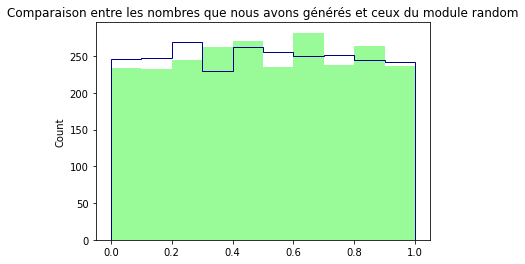

In [100]:
def comp_histo(data_1, data_2):
    plt.figure()
    plt.hist(data_1, color='palegreen', histtype='barstacked')
    plt.hist(data_2, color='darkblue', histtype='step')
    plt.title("Comparaison entre les nombres que nous avons générés et ceux du module random")
    plt.ylabel('Count')
    plt.savefig('histo_comp.png')
    plt.show()

comp_histo(numbers_python, gen_numbers)